In [20]:
%%capture
%pip install ir_datasets
%pip install demoji
%pip install pycld3
%pip install langdetect
%pip install fasttext
%pip install gensim
%pip install nltk
%pip install wordcloud
%pip install seaborn

import re
import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download("omw-1.4")

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from tqdm.notebook import tqdm

from collections import Counter
from my_utils import *

pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package punkt to /home/saitekikai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/saitekikai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/saitekikai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/saitekikai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/saitekikai/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/saitekikai/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/saitekikai/nltk_data...
[nltk_data]   Pack

In [21]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


In [22]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

# Part 1: Analysis of Queries and Documents

In [64]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

,query_id,title,description,narrative
19,20,coronavirus and ACE inhibitors,are patients taking Angiotensin-converting enzyme inhibitors (ACE) at increased risk for COVID-19?,"Looking for information on interactions between coronavirus and angiotensin converting enzyme 2 (ACE2) receptors, risk for patients taking these medications, and recommendations for these patients."
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Covid-19.
42,43,violence during pandemic,"How has the COVID-19 pandemic impacted violence in society, including violent crimes?","Looking for analyses and data on how the pandemic is impacting rates of violence, including domestic/family violence related to quarantine."
16,17,coronavirus clinical trials,are there any clinical trials available for the coronavirus,seeking specific COVID-19 clinical trials ranging from trials in recruitment to completed trials with results
49,50,mRNA vaccine coronavirus,what is known about an mRNA vaccine for the SARS-CoV-2 virus?,"Looking for studies specifically focusing on mRNA vaccines for COVID-19, including how mRNA vaccines work, why they are promising, and any results from actual clinical studies."


,doc_id,title,doi,date,abstract
165235,a662zibc,Case Fatality Rate of Cancer Patients with COVID-19 in a New York Hospital System,10.1158/2159-8290.cd-20-0516,2020-05-01,"Patients with cancer are presumed to be at increased risk from COVID-19 infection–related fatality due to underlying malignancy, treatment-related immunosuppression, or increased comorbidities. A total of 218 COVID-19–positive patients from March 18, 2020, to April 8, 2020, with a malignant diagnosis were identified. A total of 61 (28%) patients with cancer died from COVID-19 with a case fatality rate (CFR) of 37% (20/54) for hematologic malignancies and 25% (41/164) for solid malignancies. Six of 11 (55%) patients with lung cancer died from COVID-19 disease. Increased mortality was significantly associated with older age, multiple comorbidities, need for ICU support, and elevated levels of D-dimer, lactate dehydrogenase, and lactate in multivariate analysis. Age-adjusted CFRs in patie..."
176744,d3882bja,The Fox and the Crow. A need to update pest control strategies,10.1016/j.biocon.2020.108693,2020-07-03,"The recent discovery that cats and mustelids can be infected by SARS-CoV-2 may raise the question of monitoring domestic, feral and wild populations of such animals, as an adjunct to the elimination of COVID-19 in humans. Emergency solutions might consider large scale control of these animals in the wild. However, looking at science recently published on native vertebrate pest control reveals first that usual controls do not succeed in reducing animal numbers and associated damages, second that controlling can be counter-productive in increasing the infectious risks for humans and livestock. The examples of red fox and corvids are detailed in a European context, illustrating the urgent need for an ethical evaluation of ecological and economic costs and benefits of pest control strategi..."
38107,5q4pk30e,Further Recommendations on Commutability Assessment.,10.1093/clinchem/hvaa090,2020-05-14,
138868,l1kettn5,Chloroquine-induced first-episode psychosis in a patient self-medicated for covid-19,10.1016/j.biopsych.2020.05.032,2020-06-02,
90843,hsa3nsgs,Psychological distress during COVID-19 among Malayalam-speaking Indian expats in the middle east,,2020-01-01,


,query_id,doc_id,relevance,iteration
25956,16,x51jorbm,0,4.5
24192,15,vxl2flbn,1,4
59227,40,jmdd00to,0,5
38134,25,qw5x4b8x,2,2
1250,1,rbnfh89u,0,1.5


## Analysis of Documents

### Filter Covid documents

Visualize years distribution

/tmp/ipykernel_7956/1217497563.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  years.dropna(inplace=True)


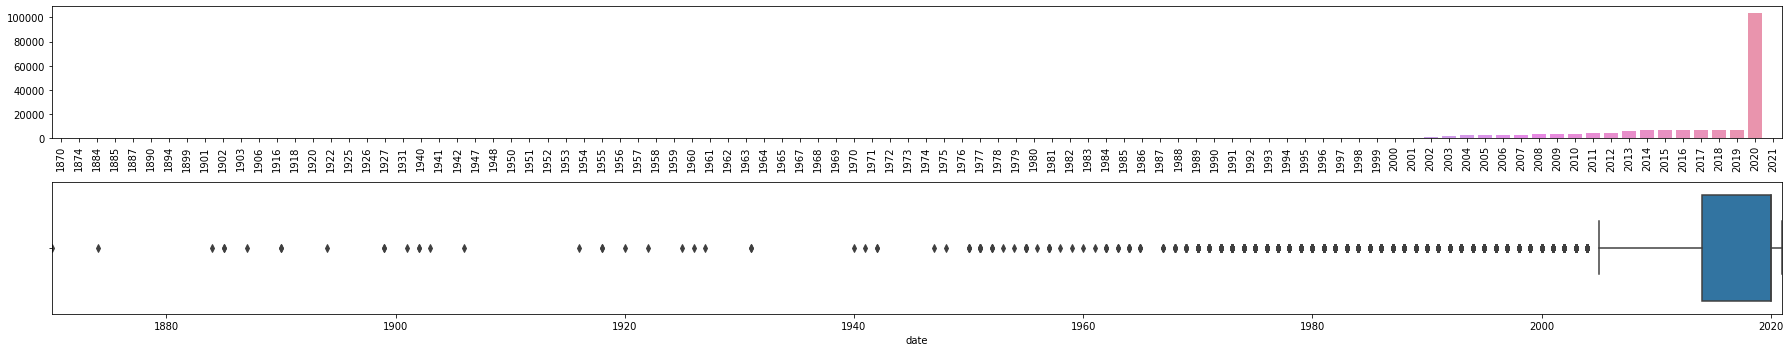

In [65]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()
fig.savefig("out/dates.png")

In [66]:
keywords = [
    "covid 19",
    "covid-19",
    "covid19",
    "sars-cov-2",
    "sarscov2",
    "sars cov 2",
    "2019-nCoV",
    "Wuhan virus",
    "Chinese flu",
    "COronaVIrusDisease",
]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    text = " ".join([row["title"], row["abstract"]])
    if any(re.findall(r"|".join(keywords), text, re.IGNORECASE)):
        keep.add(index)

    # the few documents without date contain at least one keyword
    if row["date"] and row["date"] is not pd.NaT:
        if row["date"].year >= 2019:
            if any(
                re.findall(
                    r"coronavirus | corona",
                    " ".join([row["title"], row["abstract"]]),
                    re.IGNORECASE,
                )
            ):
                keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84377, 44%


### Missing Values

In [67]:
docs.replace("", pd.NA, inplace=True)

for col in docs:
  m = sum(docs[col].isna())
  p = m / len(docs) * 100
  print(f"{col:10} {m:5} ({p:.2f}%)")

doc_id         0 (0.00%)
title          4 (0.00%)
doi        40929 (48.51%)
date          17 (0.02%)
abstract   34097 (40.41%)


In [68]:
docs[docs['title'].isna()]

,doc_id,title,doi,date,abstract
29824,3palbki5,<NA>,10.31053/1853.0605.v77.n2.28336,2020-04-29,La enfermedad por coronavirus (COVID-19) se ha expandido mundialmente y convertido en un problema prioritario de salud a nivel mundial. Se presenta el caso de un paciente con COVID-19 y se describen las características radiológicas más relevantes.
36596,j633bvoz,<NA>,10.31053/1853.0605.v77.n1.28066,2020-03-31,"Este artículo analiza la cobertura mediática del avance de la pandemia de Covid-19 en Argentina y la medida de aislamiento social preventivo y obligatorio decretada por el gobierno nacional. Destaca tendencias problemáticas y buenas prácticas según un enfoque teórico-normativo, y las vincula con las características históricas del sistema de medios en el país. Utiliza una perspectiva teórico-metodológica que concibe a la comunicación como un derecho humano fundamental, esencial en una sociedad democrática y a los medios de comunicación de masas como vehículo fundamental para su ejercicio, y se apoya en las recomendaciones formuladas por organismos internacionales, organizaciones de la sociedad civil e instituciones nacionales. Se sostiene que los medios de comunicación de masas en la Ar..."
38854,vsypmeqd,<NA>,10.31053/1853.0605.v77.n1.28031,2020-03-31,"El impacto que ha originado la enfermedad por coronavirus 2019 (COVID-19) en diferentes partes del mundo, alcanza en la actualidad 597, 072 personas contagiadas y 27,364 fallecidas según los últimos reportes. En ese contexto, en nuestro país, una zona de relevancia epidemiológica es la amazonia peruana, debido a la distribución de enfermedades endémicas como las enfermedades metaxénicas (Dengue, Malaria entre otras), en donde el problema se incrementa debido a que la infección por COVID-19 puede llevar a falsos positivos en las pruebas de cribado para Dengue. Conllevando de esa forma a un retraso en el diagnóstico de la infección por COVID-19 y una mayor diseminación del virus, debido a que en la mayor parte de los casos de Dengue no se presentan signos de alarma y el tratamiento es am..."
50912,6zjdj8w7,<NA>,10.1055/a-1149-3625,2020-04-01,"Die WHO hat am 11.03.20 die Verbreitung des SARS-CoV-2 als weltweite Pandemie eingestuft 1. Eine hohe Basisreproduktionszahl ermöglicht in einer globalisierten Welt die schnelle Verbreitung des Virus. Die Basisreproduktionszahl liegt bei SARS-CoV-2 bei 2–3.3, d. h. dass jede infizierte Person 2–3.3 weitere Personen infizieren wird, sofern keine Schutzmaßnahmen ergriffen werden 2. Diese Basisreproduktionszahl liegt höher als bei der klassischen Influenza und ist bei COVID-19, der durch das SARS-CoV-2 verursachten Lungenerkrankung, gekoppelt mit einer substanziellen Zahl an schweren Verläufen, die eine stationäre oder intensivmedizinisch-stationäre Betreuung der Patienten erfordern 3. Auch weisen erste Daten darauf hin, dass die Zahl an Langzeitbeatmungen unter den beatmungspflichtigen P..."


In [69]:
docs[docs['abstract'].isna()].sample(5)

,doc_id,title,doi,date,abstract
90240,dt9r8jcw,COVID-19: where is the national ethical guidance?,<NA>,2020-01-01,<NA>
162852,jt1v2bue,The expert COVID-19 team for older persons of the Quebec Health and Social Services Ministry,10.1007/s40520-020-01623-y,2020-06-16,<NA>
108478,rwa506fi,Mental health of health-care workers in the COVID-19 era,<NA>,2020-01-01,<NA>
125294,isi7yxwm,Weight-Based Dosing of Pembrolizumab Every 6 Weeks in the Time of COVID-19,<NA>,2020-01-01,<NA>
177239,9nw0xv4g,"Essentials of donning, doffing, and changes in endoscopy practice to reduce the risk of spreading COVID-19 during endoscopy",10.1016/j.vgie.2020.04.013,2020-06-29,<NA>


### Duplicated Values

In [70]:
duplicated = sum(docs.duplicated())
duplicated_perc = duplicated / len(docs) * 100
print(f"duplicated rows: {duplicated}, {duplicated_perc:.2f}%")

duplicated rows: 182, 0.22%


In [71]:
def print_duplicates(docs, columns=None):
  if columns is None:
    columns = docs.columns

  for col in columns:
    d = sum(docs[~docs[col].isna()][col].duplicated())
    p = d / len(docs) * 100
    print(f"{col:10} {d:5} ({p:.2f}%)")

In [72]:
print("Duplicates for each column:")
print_duplicates(docs, columns=["doc_id", "title", "doi", "abstract"])

Duplicates for each column:
doc_id      1218 (1.44%)
title      23279 (27.59%)
doi         1196 (1.42%)
abstract   10969 (13.00%)


In [73]:
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,<NA>
39326,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
48825,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
50121,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
58677,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>


In [74]:
docs.drop_duplicates(inplace=True)
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,<NA>


In [75]:
print_duplicates(docs, columns=["doc_id", "title", "doi", "abstract"])

doc_id      1036 (1.23%)
title      23097 (27.43%)
doi         1018 (1.21%)
abstract   10885 (12.93%)


In [76]:
duplicated = sum(docs.duplicated(["title", "abstract"]))
print(f"Duplicates (title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

duplicated = sum(docs.duplicated(["doc_id", "title", "abstract"]))
print(f"Duplicates (doc_id, title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

duplicated = sum(docs.duplicated(["doc_id", "title", "abstract", "doi"]))
print(f"Duplicates (doc_id, title, abstract, doi): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

Duplicates (title, abstract): 17971 (21.34%)
Duplicates (doc_id, title, abstract): 198 (0.24%)
Duplicates (doc_id, title, abstract, doi): 196 (0.23%)


Example of the same document with different dates

In [77]:
docs[docs['doc_id'] == "0fbmelx0"]

,doc_id,title,doi,date,abstract
31860,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS.,10.1016/j.socscimed.2020.113036,2020-05-15,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."
47330,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS.,10.1016/j.socscimed.2020.113036,2020-06-01,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."
141240,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS,10.1016/j.socscimed.2020.113036,2020-05-15,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."


### Detect Languages
https://modelpredict.com/language-identification-survey

In [78]:
# download the pretrained model for fasttext language identification
import requests
pretrained_model = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

results = requests.get(pretrained_model)
with open('/tmp/lid.176.bin', 'wb') as f:
    f.write(results.content)

In [79]:
from lang_identification import LanguageIdentification
lang_id = LanguageIdentification()

languages = []
for i, doc in tqdm(docs.iterrows(), total=len(docs)):
    text = doc['abstract']

    if text is pd.NA or text == "":
        text = doc['title']
    try:                                                          
        # lang = detect(text)        # language_detect  
        # lang = get_language(text)  # cld3 
        # lang = lang.language  
        lang = lang_id.predict_lang(text)                         
    except Exception as e:                                                
        lang='unknown'
    languages.append(lang)

languages = np.asarray(languages)
v, c = np.unique(languages, return_counts=True)

  0%|          | 0/84195 [00:00<?, ?it/s]

In [80]:
Counter(languages).most_common(20)

[('en', 81823),
 ('es', 1020),
 ('fr', 526),
 ('de', 426),
 ('pt', 133),
 ('zh', 72),
 ('nl', 51),
 ('it', 45),
 ('no', 39),
 ('ja', 17),
 ('da', 14),
 ('pl', 6),
 ('tr', 4),
 ('ru', 3),
 ('la', 3),
 ('sv', 2),
 ('sl', 2),
 ('ur', 2),
 ('ceb', 1),
 ('ca', 1)]

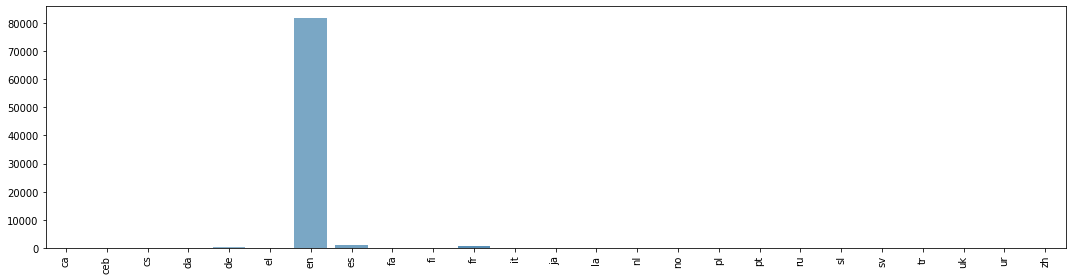

In [81]:
fig = plt.figure(figsize=(15, 4))
sns.barplot(x=v, y=c, palette="Blues_d")
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.savefig("out/languages.png")

In [82]:
print(len(docs.loc[languages == "en"]))
en_docs = docs.loc[languages == "en"]

81823


In [83]:
print(len(docs.loc[languages != "en"]))
not_en_docs = docs.loc[languages != "en"]

2372


### Find Characters

In [84]:
emojis = []
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    e1 = demoji.findall(row["title"])
    if e1:
      emojis.extend(list(e1.keys()))
  
    e2 = demoji.findall(str(row["abstract"]))
    if e2:
      emojis.extend(list(e2.keys()))

Counter(emojis)

  0%|          | 0/84195 [00:00<?, ?it/s]

TypeError: expected string or bytes-like object

In [ ]:
import sys
from unicodedata import category
punctuation_chars =  [chr(i) for i in range(sys.maxunicode) if category(chr(i)).startswith("P")]

P = []
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  if row["title"] is not pd.NA:
    t_chars = [c for c in punctuation_chars if c in row["title"]]
    if len(t_chars) > 0:
      P.extend(t_chars)

  if row["abstract"] is not pd.NA:
    a_chars = [c for c in punctuation_chars if c in row["abstract"]]
    if len(a_chars) > 0:
      P.extend(a_chars)

Counter(P).most_common()

In [3]:
import string

c = Counter(P)
for word in list(c):
    if word in string.punctuation + "–—‐“”″„’‘•′·«»§¶":
        del c[word]
c.items()

NameError: name 'P' is not defined

In [ ]:
print(string.punctuation + "–—‐“”″„’‘•′·«»§¶")

In [ ]:
WordCloud().fit_words(Counter(P)).to_image()

## Preprocessing

Apply the preprocess on the documents and the queries

In [90]:
docs = en_docs  # test only english docs
# docs = not_en_docs

In [92]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    if row["title"] is not pd.NA:
      title_tokens = preprocess(row["title"])
      docs_preprocessed.loc[index, "title"] = " ".join(title_tokens)
      titles.extend(title_tokens)

    if row["abstract"] is not pd.NA:
      abstract_tokens = preprocess(row["abstract"])
      docs_preprocessed.loc[index, "abstract"] = " ".join(abstract_tokens)
      abstracts.extend(abstract_tokens)

  0%|          | 0/81823 [00:00<?, ?it/s]

In [94]:
# docs_preprocessed.to_pickle("data/docs_processed.pkl")
docs_preprocessed.to_pickle("data/en_docs_processed.pkl")

In [88]:
queries_preprocessed = queries.copy()
for index, row in tqdm(queries.iterrows(), total=len(queries)):
    queries_preprocessed.loc[index, "title"] = " ".join(preprocess(row["title"]))
    queries_preprocessed.loc[index, "description"] = " ".join(
        preprocess(row["description"])
    )
    queries_preprocessed.loc[index, "narrative"] = " ".join(
        preprocess(row["narrative"])
    )

queries_preprocessed.to_pickle("data/queries_processed.pkl")

  0%|          | 0/50 [00:00<?, ?it/s]

## Word Cloud

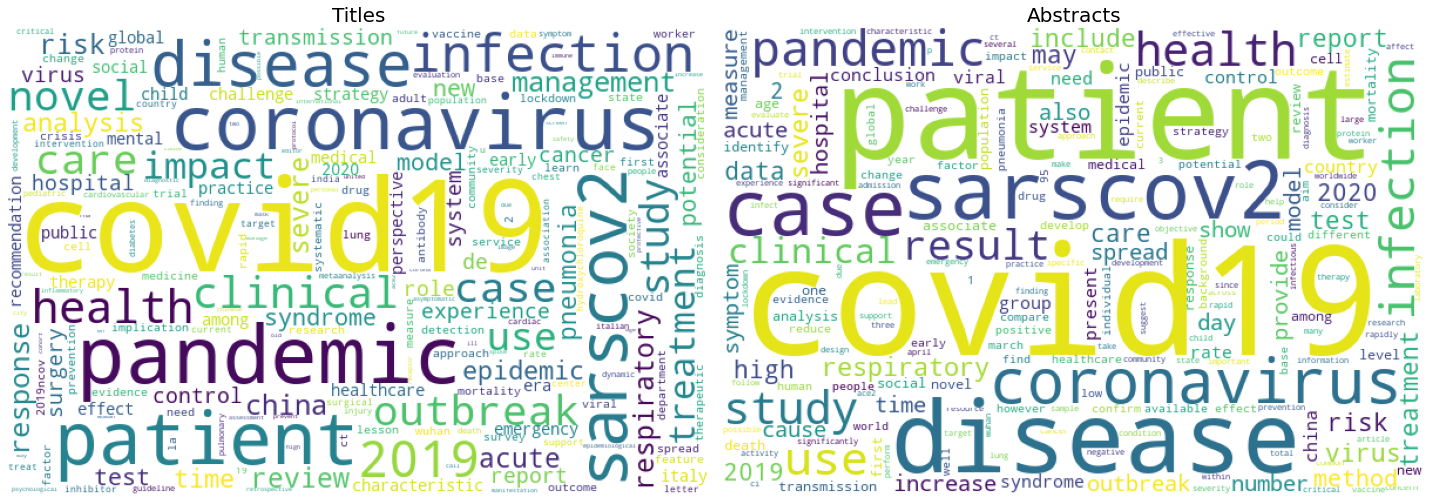

In [95]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

wc_titles.to_file("out/en/wc_titles.png")
wc_abstracts.to_file("out/en/wc_abstracts.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [96]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, _ in counter_title.most_common(k)]
top_k_abstracts = [word for word, _ in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 26645
Abstracts: 101370

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


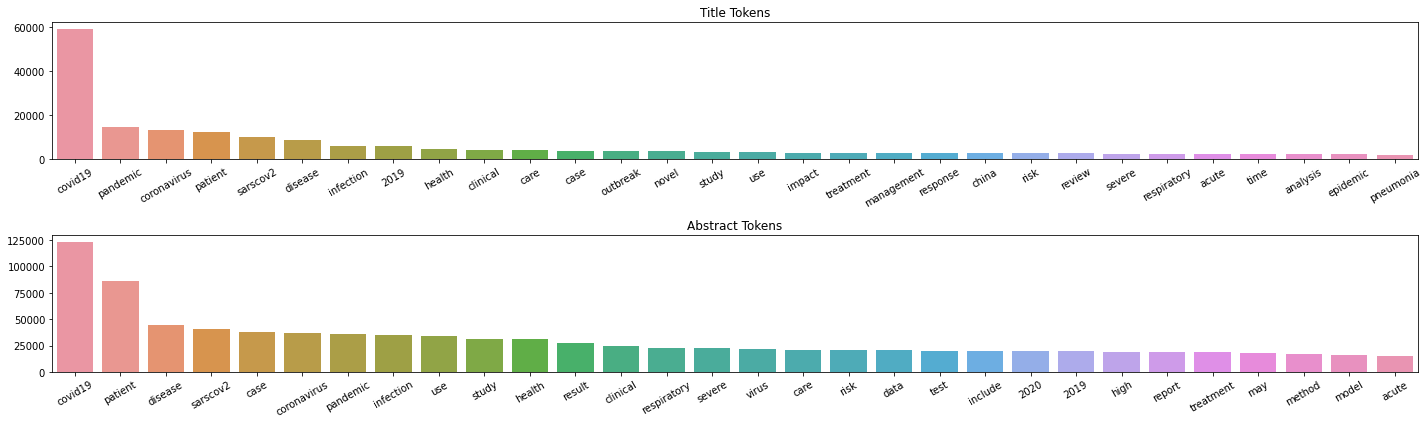

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax1.set_title("Title Tokens")
ax2.set_title("Abstract Tokens")
fig.tight_layout()

fig.savefig("out/en/most_common.png")

### Query Analysis

In [121]:
queries = pd.read_pickle("data/queries_processed.pkl")
titles = ' '.join(list(queries["title"]))
descriptions = ' '.join(list(queries["description"]))
narratives = ' '.join(list(queries["narrative"]))

print(Counter(titles.split()).most_common(10))
print(Counter(descriptions.split()).most_common(10))
print(Counter(narratives.split()).most_common(10))

[('coronavirus', 40), ('covid19', 6), ('impact', 4), ('test', 3), ('response', 2), ('immunity', 2), ('mask', 2), ('vaccine', 2), ('sarscov2', 2), ('origin', 1)]
[('covid19', 31), ('coronavirus', 8), ('sarscov2', 8), ('impact', 6), ('test', 4), ('complication', 4), ('drug', 3), ('patient', 3), ('evidence', 3), ('prevent', 3)]
[('study', 30), ('covid19', 29), ('look', 20), ('seek', 19), ('include', 18), ('information', 17), ('virus', 14), ('specific', 10), ('range', 9), ('sarscov2', 9)]


## Pairwise Similarity of Queries

Write a function that measures the pairwise similarity of the provided
queries. Create a list of similar queries and a word-cloud of their qids.

In [16]:
import os
import pyterrier as pt
from my_utils import index_model, create_index

# comment this line if your environment is already the default
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
    pt.init()

In [11]:
%%capture
%pip install gensim

import pandas as pd
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering


def compute_freqs(queries, labels):
    freqs = {}
    for i in range(max(labels)):
        # print(f"cluster {i:2} {queries.loc[labels==i]['title'].values}")

        similar_queries = queries.loc[labels==i]['query_id'].values
        for qid in similar_queries:
            freqs[qid] = len(similar_queries)

    return freqs

def print_clustered_queries(queries, labels):
    for i in range(max(labels)):
        print(f"cluster {i:2} {queries.loc[labels==i]['description'].values}")

In [12]:
AUGMENTED = False
if AUGMENTED:
    queries = pd.read_pickle('./data/queries_processed_aug.pkl')
else:
    queries = pd.read_pickle('./data/queries_processed.pkl')

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(queries['description']).toarray()

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.85)
labels = cluster.fit_predict(vectors)

print_clustered_queries(queries, labels)

cluster  0 ['sarscov2 infect people develop immunity cross protection possible'
 'guideline triaging patient infect coronavirus']
cluster  1 ['social distance impact slow spread covid19'
 'best mask prevent infection covid19'
 'much impact mask prevent spread covid19']
cluster  2 ['covid19 pandemic impact violence society include violent crime'
 'covid19 pandemic impact mental health'
 'benefit risk reopen school midst covid19 pandemic']
cluster  3 ['cardiac complication likely patient covid19'
 'kind complication related covid19 associate hypertension'
 'kind complication related covid19 associate diabetes'
 'longerterm complication recover covid19']
cluster  4 ['result phylogenetic analysis sarscov2 genome sequence'
 'observed mutation sarscov2 genome often mutation occur']
cluster  5 ['sarscov2 subtypes' 'protein structure sarscov2 spike']
cluster  6 ['evidence relate covid19 super spreader'
 'evidence value hydroxychloroquine treat covid19']
cluster  7 ['patient take angiotensincon

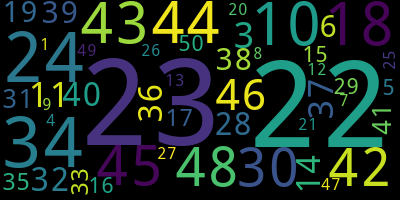

In [13]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [14]:
similar_queries = queries[labels == 3][['query_id', 'description']]
similar_queries = similar_queries.rename(columns={'query_id':'qid', 'description':'query'})
similar_queries

,qid,query
21,22,cardiac complication likely patient covid19
22,23,kind complication related covid19 associate hy...
23,24,kind complication related covid19 associate di...
33,34,longerterm complication recover covid19


In [ ]:
%%capture
en_docs = pd.read_pickle('./data/en_docs_processed.pkl')
en_docs.rename(columns={"doc_id": "docno"}, inplace=True)

index_ref_en_docs_abstract = create_index(en_docs, mode="abstract", indexer_path="./indexes/en/abstract")
index_en_docs_abstract = pt.IndexFactory.of(index_ref_en_docs_abstract)

In [30]:
# load qrels
cord19 = pt.get_dataset("irds:cord19/trec-covid")
qrels = cord19.get_qrels()
qrels = qrels.loc[qrels["label"] != -1]

In [31]:
tfidf = index_model(index_en_docs_abstract, model="TF_IDF")
bm25 = index_model(index_en_docs_abstract, model="BM25")
dirichlet_lm = index_model(index_en_docs_abstract, model="DirichletLM")

exp = pt.Experiment(
    [tfidf, bm25, dirichlet_lm],
    similar_queries,
    qrels,
    perquery=True,
    eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
    names=["TFIDF","BM25", "Dirichlet_LM"]
)
display(exp)

,name,qid,measure,value
16,BM25,22,P@5,1.000000
17,BM25,22,P@10,0.700000
18,BM25,22,nDCG@10,0.793584
19,BM25,22,RR(rel=2),1.000000
20,BM25,23,P@5,0.000000
21,BM25,23,P@10,0.300000
22,BM25,23,nDCG@10,0.164591
23,BM25,23,RR(rel=2),0.111111
24,BM25,24,P@5,1.000000
25,BM25,24,P@10,0.800000


## Try to expand the ad-hoc queries with the most similar words.

We need to define a function that can calculate the most similar word to another.
To do this we use Word2Vec.

In [33]:
from gensim.models import Word2Vec
import pandas as pd
import nltk

In [34]:
# Load the data pre-processed
docs_preprocessed = pd.read_pickle("data/docs_processed.pkl")

In [35]:
print("The dataset has {} rows of ID empty".format(len(docs_preprocessed[docs_preprocessed["doc_id"] == ""])))
print(
    "The dataset has {} rows of TITLE empty".format(
        len(docs_preprocessed[docs_preprocessed["title"] == ""])
    )
)
print(
    "The dataset has {} rows of DATE empty".format(
        len(docs_preprocessed[docs_preprocessed["date"].isnull()])
    )
)
print(
    "The dataset has {} rows of ABSTRACT empty".format(
        len(docs_preprocessed[docs_preprocessed["abstract"] == ""])
    )
)
print("The dataset has {} rows of DOI empty".format(len(docs_preprocessed[docs_preprocessed["doi"] == ""])))

The dataset has 0 rows of ID empty
The dataset has 4 rows of TITLE empty
The dataset has 17 rows of DATE empty
The dataset has 8 rows of ABSTRACT empty
The dataset has 0 rows of DOI empty


In [36]:
# We don't need all the columns
docs_preprocessed.drop(['date', 'doi', 'title'], axis=1, inplace=True)

In [37]:
print(docs_preprocessed.columns)
print(docs_preprocessed.head(5))

Index(['doc_id', 'abstract'], dtype='object')
        doc_id  \
3705  dj10dzmc   
3747  jbain7n6   
4403  5xp9yqgx   
4456  wvx6q999   
4532  mnqn1t3q   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             abstract  
3705  hdl nanoparticles 80 associated

In [38]:
docs_preprocessed = docs_preprocessed[docs_preprocessed['abstract'].notna()]
print(docs_preprocessed.head(5))

        doc_id  \
3705  dj10dzmc   
3747  jbain7n6   
4403  5xp9yqgx   
4532  mnqn1t3q   
4582  2jq626ye   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             abstract  
3705  hdl nanoparticles 80 associated protein phospholipid cholesterol cholesteryl 

In [39]:
docs_preprocessed["sent_tokens"] = docs_preprocessed.abstract
#docs_preprocessed.sent_tokens =  docs_preprocessed.sent_tokens.str.replace(r'\d+', '', regex=True)
docs_preprocessed.sent_tokens = docs_preprocessed.sent_tokens.apply(lambda input_text : [t.split() for t in  nltk.sent_tokenize(input_text)])

In [40]:
# is a list of all the sentences in the abstracts
data = docs_preprocessed.sent_tokens.sum()

In [41]:
print(type(data))
print(type(data[0]))
print(type(data[0][0]))
print(data[0][:20])

<class 'list'>
<class 'list'>
<class 'str'>
['hdl', 'nanoparticles', '80', 'associated', 'protein', 'phospholipid', 'cholesterol', 'cholesteryl', 'ester', 'potential', 'inverse', 'relation', 'hdl', 'coronary', 'artery', 'disease', 'cad', 'effect', 'hdl', 'myriad']


In [42]:
model = Word2Vec(sentences=data, window=10, sg=1, seed=1)  # sg=1 for skipgram ; sg=0 for CBOW

In [43]:
# Save the model
model.save("data/word2vec.model")
# We can load the model like that:
# model = Word2Vec.load("data/word2vec.model")

In [44]:
model.wv.most_similar('regulation', topn=1)

[('complies', 0.6710501909255981)]

In [45]:
from my_utils import most_similar, query_similar_words

In [46]:
assert most_similar('doggy doggy') == None
assert most_similar('italy') == 'spain'

In [47]:
query_similar_words('coronavirus')

'coronavirus coronavirussevere'

In [48]:
most_similar('severe')

'aimshypothesis'